In [10]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

# Command Space
# %

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [34]:
# Import required libraries
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os
import pandas as pd


## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [5]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_train_test(data_dir):
    """
    Function to load CIFAR-10 training and test data.

    Args:
    data_dir (str): Path to the directory containing CIFAR-10 data files.

    Returns:
    X_train (ndarray): Training data features
    Y_train (ndarray): Training data labels
    X_test (ndarray): Test data features
    Y_test (ndarray): Test data labels
    """
    X_train = []
    Y_train = []

    for i in range(1, 6):  # Load training data from 5 batches
        batch_file = os.path.join(data_dir, 'data_batch_' + str(i))
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        Y_train += batch_data[b'labels']

    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.array(Y_train)

    # Load test data from the test batch
    test_batch_file = os.path.join(data_dir, 'test_batch')
    test_batch_data = unpickle(test_batch_file)

    X_test = test_batch_data[b'data']
    Y_test = np.array(test_batch_data[b'labels'])

    # Reshaping and re-arranging color channels to represent RGB image required as input to CNN
    # Reshape to (50000, 3, 32, 32) and move the color channel axis to the last dimension
    X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return X_train, Y_train, X_test, Y_test


Create validation data from train set (20% split):

In [6]:
from sklearn.model_selection import train_test_split

# Directory containing CIFAR-10 data files
# data_dir = 'dataset\cifar-10-python\cifar-10-batches-py'
data_dir = 'dataset/cifar-10-python/cifar-10-batches-py'

# Load CIFAR-10 training and test data
X_train, Y_train, X_test, Y_test = load_cifar10_train_test(data_dir)

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [7]:
# Ensuring we parsed the data correctly:
print('Train Set:')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Validation Set:')
print('X_val shape: ', X_val.shape)
print('Y_val shape: ', Y_val.shape)
print('Test Set:')
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Train Set:
X_train shape:  (40000, 32, 32, 3)
Y_train shape:  (40000,)
Validation Set:
X_val shape:  (10000, 32, 32, 3)
Y_val shape:  (10000,)
Test Set:
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000,)


### Setup ImageDataGenerator

In order to make the most of fewer training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

NOTE: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have.

So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        # brightness_range=[0.2,1.0] # brightness
)

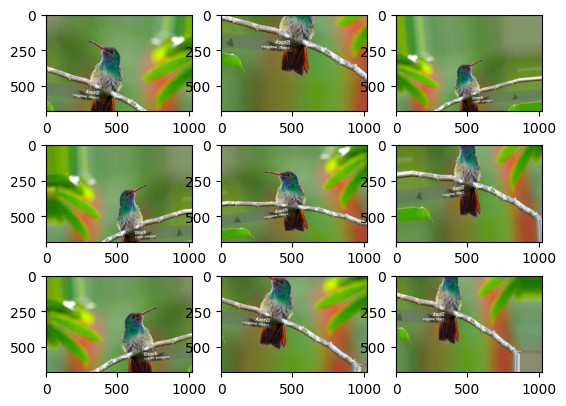

In [9]:
# Example of image augmentation on sample image:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot


img = load_img('bird.jpeg') # load image
data = img_to_array(img) # convert to numpy array
samples = expand_dims(data, 0) # expand dimension to one sample

# Prepare iterator
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers
    pyplot.imshow(image)

# show the figure
pyplot.show()
# Adapted code for displaying augmentation results: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Pre-process dataset

In [10]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)
Y_val = to_categorical(Y_val, 10)

## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [12]:
# Import required libraries
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    ax = plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, title)
    plt.show()

def plot_loss(history, title, name="undefined"):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, title)
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))
    
def save_plot(plt, name):
    """
    Function to save a plot. Call function before plt.show().

    Args:
    plt (matplotlib.pyplot object): Plot to save
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    filepath = "Graphs/" + name
    # if os.path.isfile(filepath):
    #     filepath += "_second"
    #     print("Same filename. Please alter the params_string. You will not get another warning before losing figures!!")
    plt.savefig(filepath)


In [13]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, skip_kernel_size=(1, 1), activation='relu', num_layers=2, dropout=0):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    activation (str): Activation function to use
    num_layers (int): Number of convolutional layers per block
    dropout (int): A value from 0-1 for dropout regularization

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # Create initial convolutional layer and batch normalization without an activation layer afterwards
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    
    # Create (num_layers - 1) convolutional layers with activation layer beforehand
    # Final layer does not have an activation layer as desired
    if num_layers > 1:
        for i in range(num_layers - 1):
            x = Activation(activation)(x)
            x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
            x = Dropout(dropout)(x)
            x = BatchNormalization()(x)
    

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, skip_kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = Dropout(dropout)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam', dropout=0):
    """
    Function to build a ResNet model using multiple Resnet style blocks.
    
    Args:
    init_filters (int): Number of filters in the first layer
    r_layers (list of ints): Network architecture as a list where the length of the list is the number of Residual Layers and the value of each element is the number of blocks in that layer
    conv_kernel_size (int or tuple): Size of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    conv_per_layer (int): Number of convolutional layers per residual block
    pool_size (int or tuple): Size of the pooling layer
    optimizer (String): Acceptable keras optimizers such as SGD or adam
    dropout (int): A value from 0-1 for dropout regularization

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = init_filters
    num_blocks_list = res_layers  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, conv_kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, conv_kernel_size, strides, skip_kernel_size=skip_kernel_size, num_layers=conv_per_layer)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=pool_size)(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [27]:
# Build ResNet model
resnet_model = build_resnet(init_filters=64, res_layers=[3, 3, 3], conv_kernel_size=(3,3), skip_kernel_size=(3, 3), conv_per_layer=2, pool_size=(8, 8), optimizer='adam', dropout=0.1)
resnet_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_230 (Conv2D)            (None, 32, 32, 64)   1792        ['input_14[0][0]']               
                                                                                                  
 batch_normalization_230 (Batch  (None, 32, 32, 64)  256         ['conv2d_230[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_209 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_230[

### Enabling Keras Callbacks

Callback to save the Keras model weights after every epoch that obtains the best validation accuracy thus far.

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Filepath for storing model weights
checkpoint_filepath = 'ckpt/Single Model Output/model_1'

# Defining callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [29]:
# Augmenting on the fly with datagen.flow()
batch_size=128
epochs=60

# Directly use .flow() to load our dataset in batches for training
resnet_history = resnet_model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                                  epochs = epochs, # set number of epochs
                                  steps_per_epoch = X_train.shape[0]//batch_size, # number of images composing one epoch
                                  validation_data = (X_val, Y_val), # data for validation
                                  callbacks=[model_checkpoint_callback], # model checkpoint
                                  verbose=1)

Epoch 1/60
312/312 [==============================] - ETA: 0s - loss: 1.5457 - accuracy: 0.4445

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 39s 89ms/step - loss: 1.5457 - accuracy: 0.4445 - val_loss: 2.0480 - val_accuracy: 0.3941
Epoch 2/60
312/312 [==============================] - ETA: 0s - loss: 1.1057 - accuracy: 0.6075

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 28s 88ms/step - loss: 1.1057 - accuracy: 0.6075 - val_loss: 2.8083 - val_accuracy: 0.4047
Epoch 3/60
312/312 [==============================] - ETA: 0s - loss: 0.8985 - accuracy: 0.6846

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 27s 86ms/step - loss: 0.8985 - accuracy: 0.6846 - val_loss: 1.7828 - val_accuracy: 0.5196
Epoch 4/60
312/312 [==============================] - ETA: 0s - loss: 0.7654 - accuracy: 0.7324

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 28s 88ms/step - loss: 0.7654 - accuracy: 0.7324 - val_loss: 1.2467 - val_accuracy: 0.6387
Epoch 5/60
312/312 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.7610

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 27s 86ms/step - loss: 0.6813 - accuracy: 0.7610 - val_loss: 1.1490 - val_accuracy: 0.6538
Epoch 6/60
312/312 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.7884

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 27s 86ms/step - loss: 0.6144 - accuracy: 0.7884 - val_loss: 0.7586 - val_accuracy: 0.7518
Epoch 7/60
312/312 [==============================] - 20s 64ms/step - loss: 0.5739 - accuracy: 0.8001 - val_loss: 1.5739 - val_accuracy: 0.5981
Epoch 8/60
312/312 [==============================] - ETA: 0s - loss: 0.5268 - accuracy: 0.8174

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 26s 83ms/step - loss: 0.5268 - accuracy: 0.8174 - val_loss: 0.6470 - val_accuracy: 0.7958
Epoch 9/60
312/312 [==============================] - 19s 62ms/step - loss: 0.4902 - accuracy: 0.8296 - val_loss: 0.6596 - val_accuracy: 0.7834
Epoch 10/60
312/312 [==============================] - 19s 61ms/step - loss: 0.4624 - accuracy: 0.8387 - val_loss: 0.7981 - val_accuracy: 0.7483
Epoch 11/60
312/312 [==============================] - 19s 61ms/step - loss: 0.4365 - accuracy: 0.8505 - val_loss: 0.7705 - val_accuracy: 0.7613
Epoch 12/60
312/312 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8585

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 26s 84ms/step - loss: 0.4119 - accuracy: 0.8585 - val_loss: 0.5990 - val_accuracy: 0.8057
Epoch 13/60
312/312 [==============================] - 19s 61ms/step - loss: 0.3936 - accuracy: 0.8624 - val_loss: 0.6950 - val_accuracy: 0.7986
Epoch 14/60
312/312 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8729

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 26s 82ms/step - loss: 0.3694 - accuracy: 0.8729 - val_loss: 0.6181 - val_accuracy: 0.8121
Epoch 15/60
312/312 [==============================] - ETA: 0s - loss: 0.3526 - accuracy: 0.8782

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 27s 86ms/step - loss: 0.3526 - accuracy: 0.8782 - val_loss: 0.6014 - val_accuracy: 0.8165
Epoch 16/60
312/312 [==============================] - 19s 61ms/step - loss: 0.3348 - accuracy: 0.8847 - val_loss: 1.0073 - val_accuracy: 0.7378
Epoch 17/60
312/312 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8880

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 27s 85ms/step - loss: 0.3208 - accuracy: 0.8880 - val_loss: 0.4275 - val_accuracy: 0.8618
Epoch 18/60
312/312 [==============================] - 20s 62ms/step - loss: 0.3070 - accuracy: 0.8925 - val_loss: 0.5855 - val_accuracy: 0.8400
Epoch 19/60
312/312 [==============================] - 19s 61ms/step - loss: 0.2955 - accuracy: 0.8981 - val_loss: 0.6096 - val_accuracy: 0.8199
Epoch 20/60
312/312 [==============================] - 20s 64ms/step - loss: 0.2855 - accuracy: 0.9016 - val_loss: 0.6047 - val_accuracy: 0.8277
Epoch 21/60
312/312 [==============================] - 19s 61ms/step - loss: 0.2764 - accuracy: 0.9039 - val_loss: 0.5397 - val_accuracy: 0.8505
Epoch 22/60
312/312 [==============================] - 19s 61ms/step - loss: 0.2607 - accuracy: 0.9089 - val_loss: 0.6138 - val_accuracy: 0.8355
Epoch 23/60
311/312 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.9121

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 24s 78ms/step - loss: 0.2519 - accuracy: 0.9121 - val_loss: 0.3897 - val_accuracy: 0.8745
Epoch 24/60
312/312 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.9155

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 25s 81ms/step - loss: 0.2418 - accuracy: 0.9155 - val_loss: 0.4055 - val_accuracy: 0.8754
Epoch 25/60
312/312 [==============================] - 19s 58ms/step - loss: 0.2338 - accuracy: 0.9181 - val_loss: 0.6577 - val_accuracy: 0.8189
Epoch 26/60
312/312 [==============================] - 18s 59ms/step - loss: 0.2231 - accuracy: 0.9228 - val_loss: 0.8251 - val_accuracy: 0.8039
Epoch 27/60
312/312 [==============================] - 19s 60ms/step - loss: 0.2146 - accuracy: 0.9249 - val_loss: 0.5128 - val_accuracy: 0.8563
Epoch 28/60
312/312 [==============================] - 19s 60ms/step - loss: 0.2081 - accuracy: 0.9270 - val_loss: 0.4793 - val_accuracy: 0.8695
Epoch 29/60
312/312 [==============================] - 19s 60ms/step - loss: 0.1944 - accuracy: 0.9312 - val_loss: 0.5091 - val_accuracy: 0.8598
Epoch 30/60
312/312 [==============================] - 19s 61ms/step - loss: 0.1980 - accuracy: 0.9310 - val_loss: 0.4567 - val_accuracy: 0.86

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 26s 82ms/step - loss: 0.1878 - accuracy: 0.9342 - val_loss: 0.3983 - val_accuracy: 0.8891
Epoch 32/60
312/312 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.9365

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 26s 83ms/step - loss: 0.1787 - accuracy: 0.9365 - val_loss: 0.3599 - val_accuracy: 0.8959
Epoch 33/60
312/312 [==============================] - 18s 58ms/step - loss: 0.1737 - accuracy: 0.9385 - val_loss: 0.5098 - val_accuracy: 0.8595
Epoch 34/60
312/312 [==============================] - 18s 57ms/step - loss: 0.1700 - accuracy: 0.9410 - val_loss: 0.7796 - val_accuracy: 0.8249
Epoch 35/60
312/312 [==============================] - 18s 57ms/step - loss: 0.1620 - accuracy: 0.9431 - val_loss: 0.5344 - val_accuracy: 0.8691
Epoch 36/60
312/312 [==============================] - 18s 57ms/step - loss: 0.1547 - accuracy: 0.9458 - val_loss: 0.5142 - val_accuracy: 0.8644
Epoch 37/60
312/312 [==============================] - 18s 56ms/step - loss: 0.1544 - accuracy: 0.9454 - val_loss: 0.4444 - val_accuracy: 0.8854
Epoch 38/60
312/312 [==============================] - 18s 58ms/step - loss: 0.1474 - accuracy: 0.9479 - val_loss: 0.6024 - val_accuracy: 0.85

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 26s 83ms/step - loss: 0.1205 - accuracy: 0.9581 - val_loss: 0.4214 - val_accuracy: 0.8977
Epoch 47/60
312/312 [==============================] - 19s 60ms/step - loss: 0.1134 - accuracy: 0.9612 - val_loss: 0.5005 - val_accuracy: 0.8847
Epoch 48/60
312/312 [==============================] - 18s 59ms/step - loss: 0.1115 - accuracy: 0.9608 - val_loss: 0.3843 - val_accuracy: 0.8974
Epoch 49/60
312/312 [==============================] - 18s 59ms/step - loss: 0.1120 - accuracy: 0.9598 - val_loss: 0.4865 - val_accuracy: 0.8948
Epoch 50/60
311/312 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9641

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_1\assets


312/312 [==============================] - 25s 81ms/step - loss: 0.1038 - accuracy: 0.9640 - val_loss: 0.3553 - val_accuracy: 0.9118
Epoch 51/60
312/312 [==============================] - 20s 65ms/step - loss: 0.1054 - accuracy: 0.9618 - val_loss: 0.5418 - val_accuracy: 0.8808
Epoch 52/60
312/312 [==============================] - 19s 61ms/step - loss: 0.1018 - accuracy: 0.9637 - val_loss: 0.4884 - val_accuracy: 0.8905
Epoch 53/60
312/312 [==============================] - 20s 64ms/step - loss: 0.0998 - accuracy: 0.9650 - val_loss: 0.4581 - val_accuracy: 0.8929
Epoch 54/60
312/312 [==============================] - 19s 61ms/step - loss: 0.1013 - accuracy: 0.9650 - val_loss: 0.4403 - val_accuracy: 0.8965
Epoch 55/60
312/312 [==============================] - 19s 62ms/step - loss: 0.0876 - accuracy: 0.9697 - val_loss: 0.4548 - val_accuracy: 0.8961
Epoch 56/60
312/312 [==============================] - 19s 61ms/step - loss: 0.0910 - accuracy: 0.9680 - val_loss: 0.4243 - val_accuracy: 0.90

In [ ]:
# resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, Y_val))


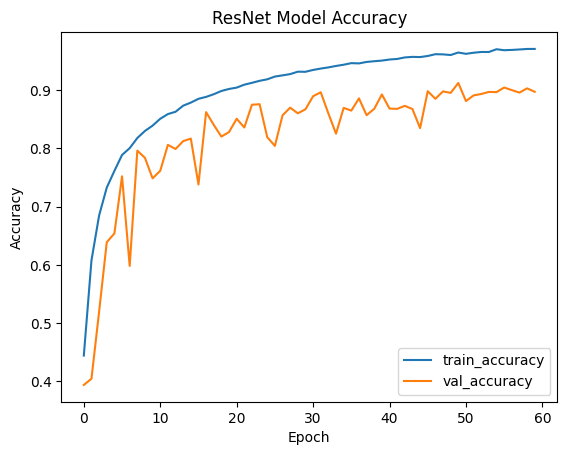

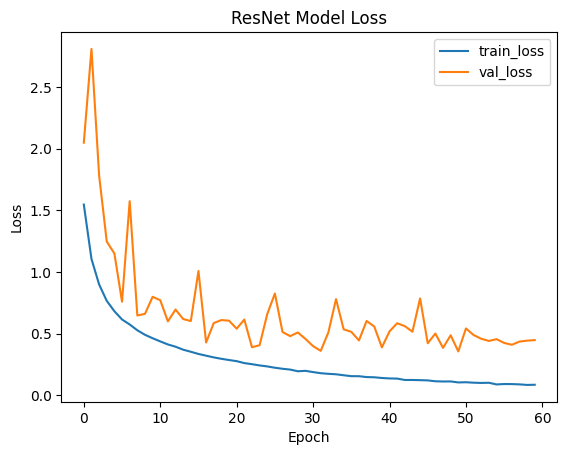

In [30]:
# Plot accuracy and loss
plot_accuracy(resnet_history, 'ResNet Model Accuracy')
plot_loss(resnet_history, 'ResNet Model Loss')


In [31]:
# Load model with max validation accuracy (our best model as saved on disk)
# Filepath for loading model checkpoint (if not above)
# checkpoint_filepath = 'ckpt/model_checkpoint_testing'

# The model weights (that are considered the best) can be loaded as -
test_model = tf.keras.models.load_model(checkpoint_filepath)

In [32]:
# Evaluate test set using best model 
print('ResNet Model:')
evaluate_model(test_model, X_test, Y_test)

ResNet Model:
Test Accuracy: 90.70%


## Run Inference on Kaggle test set

In [39]:
def save_predictions_to_csv(test_model, test_data_file, output_file):
    """
    Function to make predictions on the Kaggle test dataset and save the results to a CSV file.

    Args:
    test_model: Trained model for making predictions
    test_data_file (str): Path to the test dataset file
    output_file (str): Path to the output CSV file to save the predictions
    """
    # Load the test dataset
    test_data = unpickle(test_data_file)
    X_test_kaggle = test_data[b'data']
    image_ids = test_data[b'ids']

    # Reshape the test data
    X_test_kaggle = X_test_kaggle.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test_kaggle = X_test_kaggle / 255.0  # Normalize pixel values

    print('Load test data from Kaggle:')
    print('X_test_kaggle shape: ', X_test_kaggle.shape)
    print()

    # Make predictions using the trained model
    print('Making predictions...')
    predictions = test_model.predict(X_test_kaggle)

    # Get the predicted labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Create a DataFrame with ID and Labels columns
    results_df = pd.DataFrame({'ID': image_ids, 'Labels': predicted_labels})

    # Save the DataFrame to a CSV file
    results_df.to_csv(output_file, index=False)
    
    # Print Percent Occurrence of Each Label
    freq_arr = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    for label in predicted_labels:
        freq_arr[label] += 1
    freq_arr = freq_arr / 10000
    print("Frequency Array:", "\n",freq_arr)
    

In [40]:
# Example function call to save predictions as a CSV
save_predictions_to_csv(test_model, 'dataset/cifar_test_nolabels.pkl', 'outputs/predictions.csv')


Load test data from Kaggle:
X_test_kaggle shape:  (10000, 32, 32, 3)

Making predictions...
313/313 [==============================] - 2s 6ms/step
Frequency Array: 
 [0.0665 0.0922 0.117  0.0985 0.1035 0.0845 0.1172 0.1083 0.0988 0.1135]
